In [1]:
import sys
from pathlib import Path

import h5py as h5
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

sys.path.append('../lib')
from local_paths import analysis_dir, mplstyle_path

In [2]:
plt.style.use(mplstyle_path)

# Parameters 

In [3]:
sess_name = 'Pa200515'
unit_name = '4a'

analysis_name = 'feat_corr_map'
fix_results_dir = analysis_dir + 'feat_corr_map-hg-fix'
sacc_results_dir =  analysis_dir + 'feat_corr_map-sacc'

# Fixation-aligned map

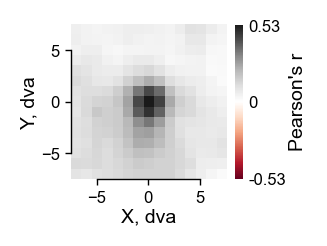

In [4]:
# load data
fix_results_dir = Path(fix_results_dir).expanduser()
results_fp = fix_results_dir / (sess_name + '.h5')
rf_ds = xr.load_dataset(results_fp, group=analysis_name+'/data')
rf_xlocs = rf_ds['rf_x'].values
rf_ylocs = rf_ds['rf_y'].values
unit_names = rf_ds['unit'].values.astype(str)
rfs = rf_ds['corr'].values

# index data
try:
    iunit = list(unit_names).index(unit_name)
except ValueError:
    iunit = list(unit_names).index('Unit/'+unit_name)
rf_step = np.zeros(2)
for i, (n, locs) in enumerate(zip('xy', (rf_xlocs,rf_ylocs))):
    step = np.unique(np.diff(locs))
    assert step.size == 1, f'{n}-location spacing is not uniform; got {step}'
    rf_step[i] = step
im_ext = (
    np.array([rf_xlocs.min(),rf_xlocs.max(),rf_ylocs.min(),rf_ylocs.max()])
    + (np.array([-.5,.5]) * rf_step[:,None]).ravel())

rf = rfs[0,0,...,iunit]
vm = np.nanmax(np.abs(rf))

# make plot
plt.figure(figsize=(1.25,1.25))
ax = plt.gca()

im = ax.imshow(rf, origin='lower', extent=im_ext, cmap='RdGy', vmin=-vm, vmax=vm)
cbar = plt.colorbar(im, ax=ax, fraction=.15, shrink=.8)

for k in ('left', 'bottom'):
    sp = ax.spines[k].set_bounds([-5,5])
ax.set_xlabel('X, dva')
ax.set_ylabel('Y, dva')

ax = cbar.ax
vm_ = round(vm, 2)
ytk = (-vm_, 0, vm_)
ax.set_yticks(ytk, tuple(map(str, ytk)))
ax.tick_params(length=0)
ax.set_ylabel('Pearson\'s r')
[v.set_visible(False) for v in ax.spines.values()]

plt.savefig('plots/fig6d.png')

# Saccade-aligned maps

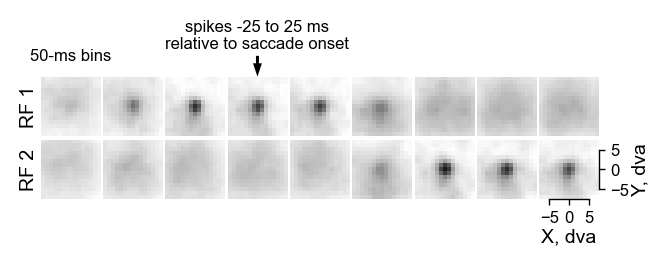

In [5]:
t_sel = slice(0, -2, 1)  # subset of time points to plot

# load data
sacc_results_dir = Path(sacc_results_dir).expanduser()
results_fp = sacc_results_dir / (sess_name + '.h5')
rf_ds = xr.load_dataset(results_fp, group=analysis_name+'/data')
ts = rf_ds['time'].values
rf_xlocs = rf_ds['rf_x'].values
rf_ylocs = rf_ds['rf_y'].values
unit_names = rf_ds['unit'].values.astype(str)
rfs = rf_ds['corr'].values
rfs_ = rfs[:2]  # keep only the two main conditiosn

with h5.File(results_fp, 'r') as f:
    sdf_suffix = f[analysis_name+'/sdf_suffix'][()].decode()
win_size = int(sdf_suffix.replace('-mwa_', ''))

# index data
try:
    iunit = list(unit_names).index(unit_name)
except ValueError:
    iunit = list(unit_names).index('Unit/'+unit_name)
rf_step = np.zeros(2)
for i, (n, locs) in enumerate(zip('xy', (rf_xlocs,rf_ylocs))):
    step = np.unique(np.diff(locs))
    assert step.size == 1, f'{n}-location spacing is not uniform; got {step}'
    rf_step[i] = step
im_ext = (
    np.array([rf_xlocs.min(),rf_xlocs.max(),rf_ylocs.min(),rf_ylocs.max()])
    + (np.array([-.5,.5]) * rf_step[:,None]).ravel())

iwin0 = np.argmin(np.abs(ts)) # find time bin nearest 0
iwins = np.nonzero((np.arange(ts.size) - iwin0 + 1) % 2)[0] # find time bins centered on iwin0 in steps of 2
iwins = iwins[ts[iwins]>-200]
iwins = iwins[t_sel]

rfs = rfs[...,iunit][:,iwins]
vm = np.nanmax(np.abs(rfs))

fig, axs = plt.subplots(2, len(iwins), figsize=(len(iwins)*.4,.8), squeeze=False)
plt.subplots_adjust(hspace=0.05, wspace=0.05)
for icond, axs_ in enumerate(axs):
    for it, ax in enumerate(axs_):
        im = ax.imshow(rfs[icond,it], origin='lower', extent=im_ext, vmin=-vm, vmax=vm, cmap='RdGy')

        if it == 0:
            ax.set_ylabel(f'RF {icond+1}')

        [v.set_visible(False) for v in ax.spines.values()]
        if icond == 1 and it == axs.shape[1]-1:
            ax.set_xlabel('X, dva')
            ax.set_ylabel('Y, dva')
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position('right')
            for k in ('right', 'bottom'):
                sp = ax.spines[k]
                sp.set_bounds([-5,5])
                sp.set_visible(True)
        else:
            ax.set_xticks([])
            ax.set_yticks([])

        if icond==0:
            if iwins[it] == iwin0:
                # label zero-centered time bin
                t = int(ts[iwin0])
                ax.set_title(f'spikes {t-win_size//2} to {t+win_size//2} ms\nrelative to saccade onset', fontsize=6, pad=10)
                ax.arrow(.5,1.35,0,-.35,transform=ax.transAxes, clip_on=False, length_includes_head=True, zorder=2, width=.05, lw=0, fc='k')
            elif it == 0:
                ax.set_title(f'50-ms bins', fontsize=6)

plt.savefig('plots/fig6e.png')

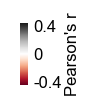

In [6]:
plt.figure(figsize=(.05,.4))
ax = plt.gca()
plt.colorbar(im, cax=ax)

vm = (vm // .1) * .1
ytk = (-vm, 0, vm)
ax.set_yticks(ytk, tuple(map(str, ytk)))
ax.tick_params(length=0, labelsize=6)
ax.set_ylabel('Pearson\'s r', fontsize=6)
[v.set_visible(False) for v in ax.spines.values()];

plt.savefig('plots/fig6e_cbar.png')